In [1]:
import torch
import scvi
import scgen
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion
Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [2]:
# from gradients import run_expected_jacobian_scanvi, run_integrated_jacobian_scanvi

def batch_to_dict_scanvi(batch):
    return dict(x=batch["X"], batch_index=batch["batch"])

def batch_jacobian(outpt, inpt):
    n_out = outpt.shape[-1]
    
    jacs = []
    
    ones = torch.ones(outpt.shape[0]).to(outpt.device)
    
    for i in range(n_out):
        retain_graph = i!= n_out-1
        jacs.append(torch.autograd.grad(outpt[..., i], inpt, ones, retain_graph=retain_graph)[0])

    return torch.stack(jacs, dim=-1)

def expected_jacobian_step(func, inpt_dict, backprop_inpt_key, prime_inpt):
    x = inpt_dict[backprop_inpt_key]
    x_prime = prime_inpt.to(x.device)
    
    unif_coef = torch.rand(x.shape[0])[:, None].to(x.device)
    
    x_diff = x - x_prime
    
    new_inpt_dict = dict(inpt_dict)
    new_inpt_dict[backprop_inpt_key] = x_prime + x_diff * unif_coef

#     out = func(**new_inpt_dict)
    out = func(new_inpt_dict)  # edited bc I can't figure out how otherwise
    
    jac = batch_jacobian(out, x)
    
    return jac * x_diff[..., None].detach()

def integrated_jacobian(func, inpt_dict, backprop_inpt_key, prime_inpt=None, n_steps=10):
    x = inpt_dict[backprop_inpt_key]
    if prime_inpt is not None:
        x_prime = prime_inpt.to(x.device)
    else:
        x_prime = torch.zeros_like(x)
    
    x_diff = x - x_prime
    
    jacs = []
    
    new_inpt_dict = dict(inpt_dict)
    
    for i in range(n_steps):
        new_inpt_dict[backprop_inpt_key] = x_prime + x_diff * (i+1)/n_steps
        
        out = func(new_inpt_dict)  # edited
        
        jacs.append(batch_jacobian(out, x))
    
    return sum(jacs) * (1/n_steps) * x_diff[..., None].detach()

def run_expected_jacobian_scanvi(module_func, dl_base, dl_prime, n_steps=10, apply_abs=False, sum_obs=False):
    expected_jacs = []

    for batch in dl_base:
        inpt_dict = batch_to_dict_scanvi(batch)
        inpt_dict["x"].requires_grad = True
        if torch.cuda.is_available():
            inpt_dict["x"] = inpt_dict["x"].cuda()

        inpt_batch_size = inpt_dict["x"].shape[0]

        jacs_batch = []
        for i, batch_prime in enumerate(dl_prime):
            if i > n_steps-1:
                break

            prime_inpt = batch_to_dict_scanvi(batch_prime)["x"]
            if inpt_batch_size < prime_inpt.shape[0]:
                prime_inpt = prime_inpt[:inpt_batch_size]

            jacs_batch.append(expected_jacobian_step(module_func, inpt_dict, "x", prime_inpt))

        exp_jac_batch = sum(jacs_batch) / len(jacs_batch)
        if apply_abs:
            exp_jac_batch = exp_jac_batch.abs()
        
        expected_jacs.append(exp_jac_batch.cpu() if not sum_obs else exp_jac_batch.sum(0).cpu())
        
    if sum_obs:
        result = torch.stack(expected_jacs).sum(0)
    else:
        result = torch.cat(expected_jacs)
    return result

def run_integrated_jacobian_scanvi(module_func, dl_base, n_steps=10, apply_abs=False, sum_obs=False):
    integrated_jacs = []

    for batch in dl_base:
        inpt_dict = batch_to_dict_scanvi(batch)
        inpt_dict["x"].requires_grad = True
        if torch.cuda.is_available():
            inpt_dict["x"] = inpt_dict["x"].cuda()
        
        integr_jac_batch = integrated_jacobian(module_func, inpt_dict, "x", n_steps=n_steps)
        if apply_abs:
            integr_jac_batch = integr_jac_batch.abs()

        integrated_jacs.append(integr_jac_batch.cpu() if not sum_obs else integr_jac_batch.sum(0).cpu())
        
    if sum_obs:
        result = torch.stack(integrated_jacs).sum(0)
    else:
        result = torch.cat(integrated_jacs)
    return result

In [3]:
base_path = '/home/icb/yuge.ji/projects/feature-attribution-sc'
adata = sc.read(f'{base_path}/datasets/2301_scgen_norman19.h5ad')
# adata = adata[~adata.obs.perturbation_name.isin(['C19orf26', 'C3orf72', 'KIAA1804'])].copy()  # do not match to gene, remove
adata

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 69570 × 919
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gui

In [7]:
from scvi import REGISTRY_KEYS
pert_names = model.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY)['categorical_mapping']

## Running IG and EG for a single model

In [19]:
file = 'scgen_norman19_model2_shuffled_v2'
model = scgen.SCGEN.load(f'{base_path}/models/{file}', adata=adata)
model

INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model2_
         shuffled_v2/model.pt already downloaded                                             


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


SCGEN Model with the following params: 
n_hidden: 400, n_latent: 30, n_layers: 2, dropout_rate: 0.2
Training status: Trained

In [22]:
forw = lambda inpt_dict: model.module.inference(inpt_dict['x'])['z']

In [24]:
%%time
# sum abs values

batch_size = 50
all_abs_exp_jac = []
for pert in pert_names:  # loop because of memory

    indices = np.where(adata.obs["perturbation_name"] == pert)[0]
    cutoff = len(indices)%batch_size
    if cutoff == 0:
        pass
    else:
        indices = indices[:-cutoff]
    
    dl_base = model._make_data_loader(adata=adata, shuffle=False, indices=indices, batch_size=batch_size)
    dl_prime = model._make_data_loader(
        adata=adata, shuffle=True,
        indices=np.random.choice(range(adata.obs.shape[0]), size=len(indices), replace=False),
        batch_size=batch_size
    )
    
    exp_jac_ds = run_expected_jacobian_scanvi(forw, dl_base, dl_prime, apply_abs=True, sum_obs=True)
    
    all_abs_exp_jac.append(exp_jac_ds)

CPU times: user 1h 21min 34s, sys: 8.73 s, total: 1h 21min 43s
Wall time: 5min 9s


In [25]:
means = pd.DataFrame(torch.stack(all_abs_exp_jac).sum(2).numpy().T, index=adata.var_names, columns=pert_names)

Take the average contribution per gene per **perturbation** to get a ranking of all genes per perturbation.

In [26]:
means.to_csv("../../outputs/expected_gradients/task_1_absolute_expected_grads_v2.csv")

Run integrated gradients:

In [27]:
%%time
batch_size = 200
all_abs_integr_jac = []
for pert in pert_names:  # loop because of memory

    indices = np.where(adata.obs["perturbation_name"] == pert)[0]

    dl_base = model._make_data_loader(adata=adata, shuffle=False, indices=indices, batch_size=batch_size)
    
    integr_jac_ds = run_integrated_jacobian_scanvi(forw, dl_base, apply_abs=True, sum_obs=True)
    
    all_abs_integr_jac.append(integr_jac_ds)

CPU times: user 45min 8s, sys: 34.6 s, total: 45min 42s
Wall time: 3min 1s


In [28]:
means_int = pd.DataFrame(torch.stack(all_abs_integr_jac).sum(2).numpy().T, index=adata.var_names, columns=pert_names)

In [29]:
means_int.to_csv("../../outputs/integrated_gradients/task_1_absolute_integrated_grads_v2.csv")

Going to discard taking just the sum for now because I'd argue it's always less meaningful than the absolute. 

In [ ]:
# pd.DataFrame(avg_abs_exp_jac.numpy(), columns=list(range(100)), index=adata.var_names.tolist()).to_csv(f"{path}/expected_gradients/task_1_absolute_sum_expected_grads.csv", index_label="Gene")

In [27]:
# pd.DataFrame(avg_abs_integr_jac.numpy(), columns=list(range(100)), index=adata.var_names.tolist()).to_csv(f"{path}/integrated_gradients/task_1_absolute_sum_integrated_grads.csv", index_label="Gene")

## Running just EG for multiple scGen models

Load all models.

In [4]:
import os

models = {}
for file in os.listdir(f'{base_path}/models'):
    if 'scgen' in file and 'v2' in file:
        print('loading', file)
        models['_'.join(file.split('_')[1:])] = scgen.SCGEN.load(f'{base_path}/models/{file}', adata=adata)

models.keys()

loading scgen_norman19_model2_random_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model2_
         random_v2/model.pt already downloaded                                               


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


loading scgen_norman19_model1_shuffled_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model1_
         shuffled_v2/model.pt already downloaded                                             
loading scgen_norman19_model0_shuffled_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model0_
         shuffled_v2/model.pt already downloaded                                             


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


loading scgen_norman19_model1_random_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model1_
         random_v2/model.pt already downloaded                                               
loading scgen_norman19_model4_shuffled_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model4_
         shuffled_v2/model.pt already downloaded                                             


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


loading scgen_norman19_model3_shuffled_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model3_
         shuffled_v2/model.pt already downloaded                                             
loading scgen_norman19_model4_random_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model4_
         random_v2/model.pt already downloaded                                               


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


loading scgen_norman19_model0_random_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model0_
         random_v2/model.pt already downloaded                                               
loading scgen_norman19_model2_shuffled_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model2_
         shuffled_v2/model.pt already downloaded                                             


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


loading scgen_norman19_model3_random_v2
INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model3_
         random_v2/model.pt already downloaded                                               


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


dict_keys(['norman19_model2_random_v2', 'norman19_model1_shuffled_v2', 'norman19_model0_shuffled_v2', 'norman19_model1_random_v2', 'norman19_model4_shuffled_v2', 'norman19_model3_shuffled_v2', 'norman19_model4_random_v2', 'norman19_model0_random_v2', 'norman19_model2_shuffled_v2', 'norman19_model3_random_v2'])

In [5]:
def expected_gradients(model, adata, batch_size=50):
    forw = lambda inpt_dict: model.module.inference(inpt_dict['x'])['z']
    
    pert_names = model.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY)['categorical_mapping']
    
    all_abs_exp_jac = []
    for pert in pert_names:  # loop because of memory

        indices = np.where(adata.obs["perturbation_name"] == pert)[0]
        cutoff = len(indices)%batch_size
        if cutoff == 0:
            pass
        else:
            indices = indices[:-cutoff]

        dl_base = model._make_data_loader(adata=adata, shuffle=False, indices=indices, batch_size=batch_size)
        dl_prime = model._make_data_loader(
            adata=adata, shuffle=True,
            indices=np.random.choice(range(adata.obs.shape[0]), size=len(indices), replace=False),
            batch_size=batch_size
        )

        exp_jac_ds = run_expected_jacobian_scanvi(forw, dl_base, dl_prime, apply_abs=True, sum_obs=True)

        all_abs_exp_jac.append(exp_jac_ds)

    return all_abs_exp_jac

In [8]:
from tqdm import tqdm

for descript, model in tqdm(models.items()):
    model._validate_anndata(adata)
    exp_jac = expected_gradients(model, adata)
    means = pd.DataFrame(torch.stack(exp_jac).sum(2).numpy().T, index=adata.var_names, columns=pert_names)
    means.to_csv(f"{descript}_task_1_absolute_EG_v2.csv", index_label="Gene")

  0%|                                                                                                                                                                                                                                | 0/10 [06:36<?, ?it/s]


Save the full dimensions of one of the expected gradients calculation for further analysis.

In [18]:
arr = np.array([m.numpy() for m in exp_jac])
arr.shape

(106, 919, 30)

In [20]:
save_loc = f'{descript}_task_1_absolute_EG_v2.npy'
np.save(save_loc, arr)
print(save_loc)

norman19_model2_random_v2_task_1_absolute_EG_v2.npy


### Check correlation of latent dimensions

Take only the latent representation for a single perturbation at a time.

In [23]:
pert_names[0]

'AHR'

In [26]:
eg_fa = pd.DataFrame(arr[0], index=adata.var_names)
eg_fa.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
gene_symbols,,,,,,,,,,,,,,,,,,,,,
SAMD11,0.160041,0.360837,0.109676,0.264826,0.096089,0.697738,0.285133,0.151908,0.133894,0.089199,...,0.141775,0.358735,0.087869,0.279916,0.111176,0.302441,0.099091,0.274404,0.332068,0.295174
HES4,3.264109,2.936340,3.439859,1.696647,8.761532,1.805857,6.860506,13.679716,3.964677,2.287496,...,7.214108,2.331906,6.971149,3.106840,7.344008,7.648760,5.666132,1.965961,3.573261,1.691008
ISG15,2.789724,4.937125,2.474782,4.750522,9.730717,15.952799,15.699591,20.238352,4.734634,2.979782,...,3.103088,5.165283,10.407179,12.589308,4.706276,8.094058,2.540349,6.529434,2.353880,3.107928


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


<Figure size 700x600 with 0 Axes>

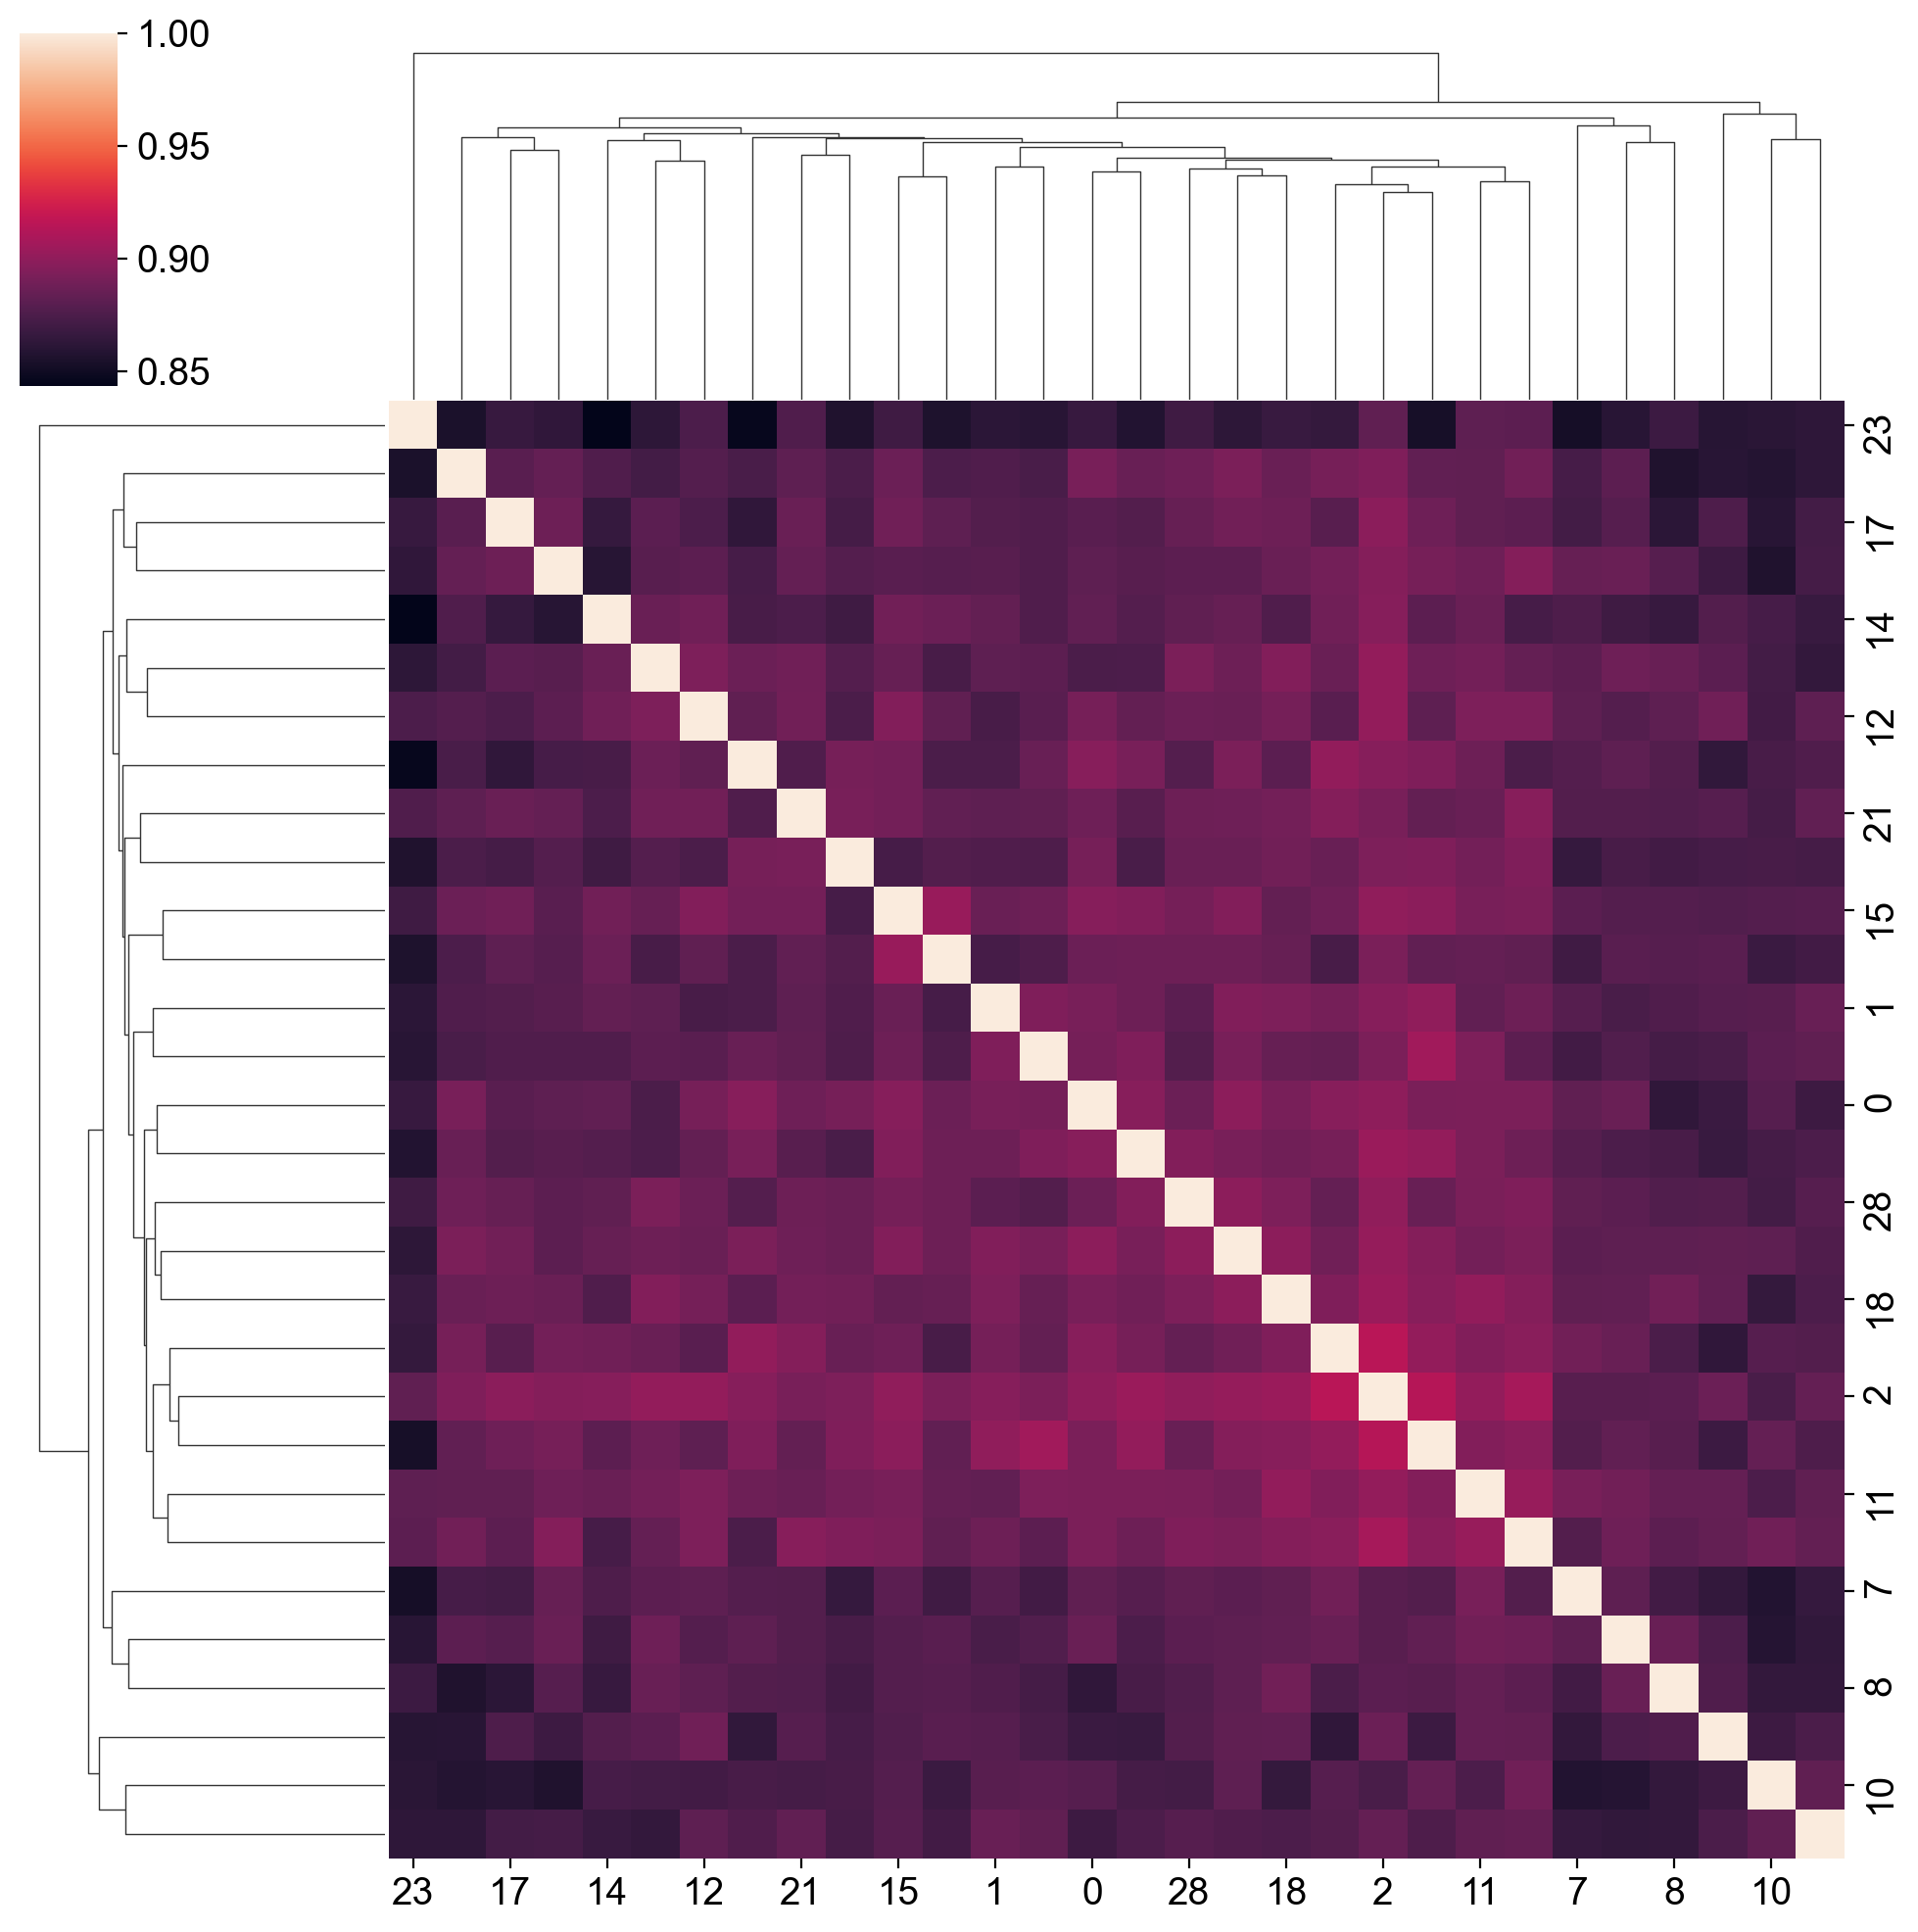

In [29]:
plt.figure(figsize=(7, 6))
sns.clustermap(eg_fa.corr('spearman'))